In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
#Loading Dataset
data = pd.read_csv("https://raw.githubusercontent.com/RafsanJany-44/Thesis_Project/main/All_DATA/without_sn_and_Epoch/EEG_HMC.csv")

In [3]:
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

In [4]:
from sklearn.preprocessing import label_binarize
cls=["W", "N1", "N2","N3","R"]
y = label_binarize(y, classes=cls)

In [9]:
#Encoding Categorical the sleep_stage
from sklearn.preprocessing import LabelEncoder
LE1 = LabelEncoder()
Y = np.array(LE1.fit_transform(y))

ValueError: ignored

In [ ]:
#Encoding Categorical variable Geography
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct =ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[1])],remainder="passthrough")
X = np.array(ct.fit_transform(X))

In [6]:
#Splitting dataset into training and testing dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [7]:
#Performing Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
len(X_train)

86760

In [ ]:
len(X_test)

21691

In [ ]:
X_train.shape


(86760, 215)

In [8]:
from sklearn.multiclass import OneVsRestClassifier

model = keras.Sequential([
    keras.layers.Dense(100, input_shape=(215,), activation='relu'), # input layer
    #keras.layers.Dense(350, activation='sigmoid'),
    #keras.layers.Dense(250, activation='sigmoid'),
    #keras.layers.Dense(150, activation='sigmoid'),
    keras.layers.Dense(50, activation='softmax')                    # output layer
])

'''model = keras.Sequential([
    keras.layers.Dense(100, input_shape=(215,), activation='relu'), # input layer
    #keras.layers.Dense(350, activation='sigmoid'),
    #keras.layers.Dense(250, activation='sigmoid'),
    keras.layers.Dense(75, activation='sigmoid'),
    keras.layers.Dense(25, activation='softmax')                    # output layer
])'''




model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=560)

Epoch 1/560


ValueError: ignored

In [ ]:
model.evaluate(X_test, y_test)

678/678 [==============================] - 2s 2ms/step - loss: 1.6069 - accuracy: 0.7382


[1.6068832874298096, 0.738232433795929]

#Confusion Matrix

In [ ]:
y_predicted = model.predict(X_test)
y_predicted_labels = [np.argmax(i) for i in y_predicted]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test, y_predicted_labels))
print(classification_report(y_test,y_predicted_labels))
print("Accurecy: ",accuracy_score(y_test, y_predicted_labels))

[[ 916  549   27  381  495]
 [ 454 5988  829  459  161]
 [  17  775 3413   29   20]
 [ 278  392   31 2586   87]
 [ 415  166   26   87 3110]]
              precision    recall  f1-score   support

           0       0.44      0.39      0.41      2368
           1       0.76      0.76      0.76      7891
           2       0.79      0.80      0.80      4254
           3       0.73      0.77      0.75      3374
           4       0.80      0.82      0.81      3804

    accuracy                           0.74     21691
   macro avg       0.70      0.71      0.71     21691
weighted avg       0.73      0.74      0.74     21691

Accurecy:  0.738232446636854


In [ ]:
def confusion_details(y_test,y_pred):
    labels = list(set(y_test))
    labels.sort()

    print("Total labels: %s -> %s" % (len(labels), labels))

    df = pd.DataFrame(
        data=confusion_matrix(y_test, y_pred, labels=labels),
        columns=labels,
        index=labels
    )

    print(df)

    print()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")
    print()
    #
    # Local (metrics per class)
    #
    tps = {}
    fps = {}
    fns = {}
    tns = {}

    precision_local = {}
    recall_local = {}
    f1_local = {}
    accuracy_local = {}
    specificity_local={}

    for label in labels:
        tps[label] = df.loc[label, label]
        fps[label] = df[label].sum() - tps[label]
        fns[label] = df.loc[label].sum() - tps[label]
        tns[label]=len(y_test) - (tps[label] + fps[label] + fns[label])
        
        tp, fp, fn, tn = tps[label], fps[label], fns[label], tns[label]
        
        precision_local[label] = tp / (tp + fp) if (tp + fp) > 0. else 0.
        specificity_local[label] = tn / (tn + fp) if (tn + fp) > 0. else 0.
        recall_local[label] = tp / (tp + fn) if (tp + fp) > 0. else 0.
        p, r = precision_local[label], recall_local[label]
        
        f1_local[label] = 2. * p * r / (p + r) if (p + r) > 0. else 0.
        accuracy_local[label] = tp / (tp + fp + fn) if (tp + fp + fn) > 0. else 0.



    print("#-- Local measures --#")
    print("True Positives(TP):", tps)
    print("False Positives(FP):", fps)
    print("True Negatives(TN):", tns)
    print("False Negatives(FN):", fns)
    print("----------------------------")

    print("Precision:", precision_local)
    print("Recall/Sensitivity:", recall_local)
    print("Specificity:",specificity_local)
    print("F1-Score:", f1_local)
    print("Accuracy:", accuracy_local)


    print()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")
    print()
    #
    # Global
    #
    micro_averages = {}
    macro_averages = {}

    correct_predictions = sum(tps.values())
    true_negative=sum(tns.values())

    den = sum(list(tps.values()) + list(fps.values()))
    micro_averages["Precision"] = 1. * correct_predictions / den if den > 0. else 0.

    den = sum(list(tps.values()) + list(fns.values()))
    micro_averages["Recall"] = 1. * correct_predictions / den if den > 0. else 0.

    den = sum(list(tns.values()) + list(fps.values()))
    micro_averages["Specificity"] = 1. * true_negative / den if den > 0. else 0.


    micro_avg_p, micro_avg_r = micro_averages["Precision"], micro_averages["Recall"]
    micro_averages["F1-score"] = 2. * micro_avg_p * micro_avg_r / (micro_avg_p + micro_avg_r) if (micro_avg_p + micro_avg_r) > 0. else 0.

    macro_averages["Precision"] = np.mean(list(precision_local.values()))
    macro_averages["Recall"] = np.mean(list(recall_local.values()))
    macro_averages["Specificity"]=np.mean(list(specificity_local.values()))


    macro_avg_p, macro_avg_r = macro_averages["Precision"], macro_averages["Recall"]
    macro_averages["F1-Score"] = 2. * macro_avg_p * macro_avg_r / (macro_avg_p + macro_avg_r) if (macro_avg_p + macro_avg_r) > 0. else 0.

    total_predictions = df.values.sum()
    accuracy_global = correct_predictions / total_predictions if total_predictions > 0. else 0.

    print("#-- Global measures --#")
    print("Micro-Averages:", micro_averages)
    print("Macro-Averages:", macro_averages)
    print("Correct predictions:", correct_predictions)
    print("Total predictions:", total_predictions)
    print("Accuracy:", accuracy_global)


    print()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")
    print()



    accuracy_local_new = {}
    for label in labels:
        tp, fp, fn, tn = tps[label], fps[label], fns[label], tns[label]
        accuracy_local_new[label] = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0. else 0.

    total_true = sum(list(tps.values()) + list(tns.values()))
    total_predictions = sum(list(tps.values()) + list(tns.values()) + list(fps.values()) + list(fns.values()))
    accuracy_global_new = 1. * total_true / total_predictions if total_predictions > 0. else 0.

    print("Accuracy (per class), with TNs:", accuracy_local_new)
    print("Accuracy (per class), without TNs:", accuracy_local)
    print("Accuracy (global), with TNs:", accuracy_global_new)
    print("Accuracy (global), without TNs:", accuracy_global)

In [ ]:
confusion_details(y_test,y_predicted_labels)

Total labels: 5 -> [0, 1, 2, 3, 4]
     0     1     2     3     4
0  916   549    27   381   495
1  454  5988   829   459   161
2   17   775  3413    29    20
3  278   392    31  2586    87
4  415   166    26    87  3110

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

#-- Local measures --#
True Positives(TP): {0: 916, 1: 5988, 2: 3413, 3: 2586, 4: 3110}
False Positives(FP): {0: 1164, 1: 1882, 2: 913, 3: 956, 4: 763}
True Negatives(TN): {0: 18159, 1: 11918, 2: 16524, 3: 17361, 4: 17124}
False Negatives(FN): {0: 1452, 1: 1903, 2: 841, 3: 788, 4: 694}
----------------------------
Precision: {0: 0.4403846153846154, 1: 0.760864040660737, 2: 0.7889505316689782, 3: 0.7300959909655562, 4: 0.8029950942421895}
Recall/Sensitivity: {0: 0.38682432432432434, 1: 0.7588391838803701, 2: 0.8023037141513869, 3: 0.7664493183165383, 4: 0.8175604626708728}
Specificity: {0: 0.9

**Now we need to draw the confusion matrix to show where our model is doing mistakes**
<br>
<br>
***Tensorflow has its own confusion matrix function where "labels" is the truth data and "predictions" is the predicted data***

In [ ]:
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)

Text(69.0, 0.5, 'Truth')

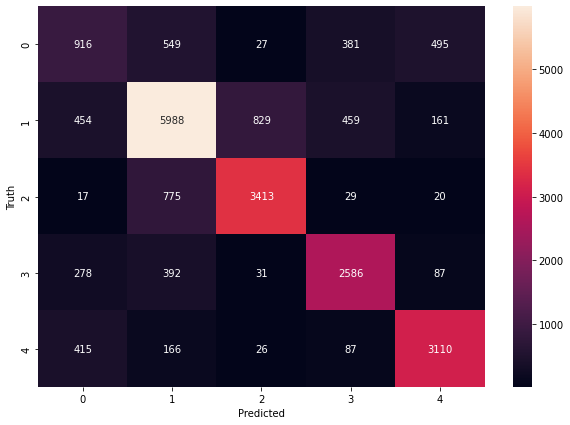

In [ ]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d') # here, cm is called to be visualized
plt.xlabel('Predicted')
plt.ylabel('Truth')

#ROC graph